In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vaibhavipaliwal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [64]:
data = pd.read_csv("data/reviews.csv")

In [65]:
print(f"dataset shape {data.shape}")
data.head()

dataset shape (568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [66]:
#Columns Features
print(f"Feature Name:{data.columns.values}")
#Check for null values 
print("\nMissing values in each column:")
print(data.isnull().sum())



Feature Name:['Id' 'ProductId' 'UserId' 'ProfileName' 'HelpfulnessNumerator'
 'HelpfulnessDenominator' 'Score' 'Time' 'Summary' 'Text']

Missing values in each column:
Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


In [67]:
# 1. Drop all rows that contain any null values
data.dropna(inplace=True)


In [68]:
print(f"Dataset shape after dropping null values: {data.shape}")


Dataset shape after dropping null values: (568401, 10)


In [69]:
#Double-check that all nulls are gone
print("\nRemaining null values:")
print(data.isnull().sum())


Remaining null values:
Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64


In [70]:
# 1. Create the 'length' column based on your 'Text' column
data['length'] = data['Text'].apply(len)
# 2. View the first 5 rows to see the new column at the end
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,length
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,263
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,190
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,509
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,219
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,140


In [71]:
#just to check the length column
# Check the 10th record 
print(f"'Text' column value: {data.iloc[10]['Text']}")
print(f"Calculated Length: {len(data.iloc[10]['Text'])}")
print(f"Value in 'length' column: {data.iloc[10]['length']}")

'Text' column value: I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!
Calculated Length: 779
Value in 'length' column: 779


In [72]:
data.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
length                     int64
dtype: object

In [73]:
# Analyzing the 'Score' column in your dataset
print(f"Rating value count: \n{data['Score'].value_counts()}")

Rating value count: 
Score
5    363102
4     80654
1     52264
3     42638
2     29743
Name: count, dtype: int64


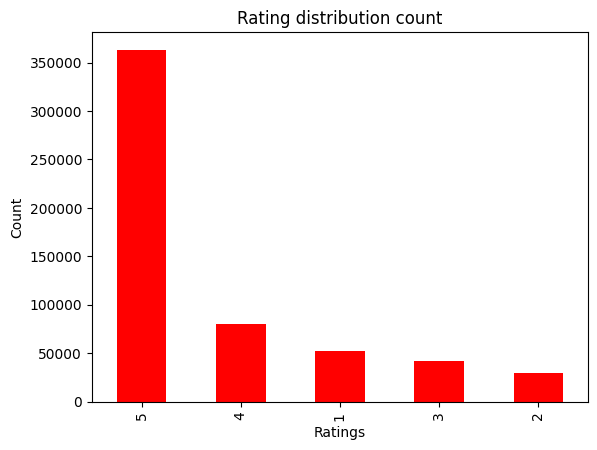

In [74]:
#lets point the above values in a bar graph 
# Bar plot to visualize the total counts of each rating
data['Score'].value_counts().plot.bar(color = 'red')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [75]:
# Finding the percentage distribution of each rating in your dataset
print(f"Rating value count - percentage distribution: \n{round(data['Score'].value_counts()/data.shape[0]*100,2)}")

Rating value count - percentage distribution: 
Score
5    63.88
4    14.19
1     9.19
3     7.50
2     5.23
Name: count, dtype: float64


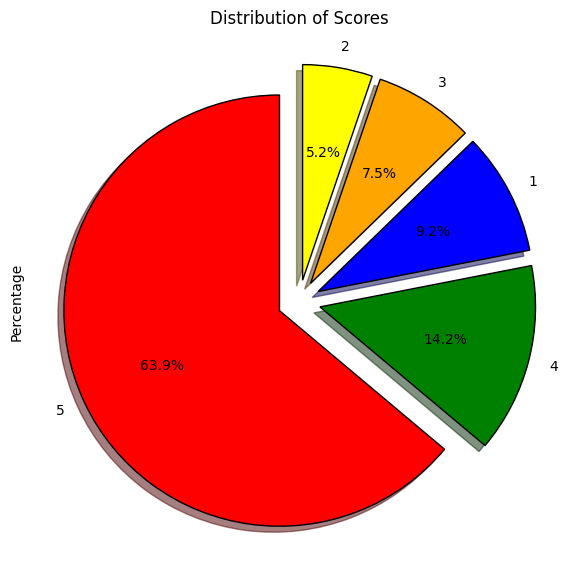

In [76]:


# 1. Prepare the data (Percentages)
tags = data['Score'].value_counts() / data.shape[0]

# 2. Set up the figure
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green', 'blue', 'orange', 'yellow')
wp = {'linewidth': 1, "edgecolor": 'black'}
explode = (0.1, 0.1, 0.1, 0.1, 0.1)

# 3. Create the pie chart
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, 
          startangle=90, wedgeprops=wp, explode=explode, label='Percentage')

# 4. Display the chart
plt.title('Distribution of Scores')
plt.show()

In [77]:
# Create the 'feedback' column to match the tutorial
data['feedback'] = data['Score'].apply(lambda x: 1 if x >= 3 else 0)

# Now run the exact code from your reference image
print(f"Feedback value count: \n{data['feedback'].value_counts()}")

Feedback value count: 
feedback
1    486394
0     82007
Name: count, dtype: int64


In [78]:
# 1. Extracting the 'Text' value for one record with feedback = 0 (Negative)
review_0 = data[data['feedback'] == 0].iloc[1]['Text']
print("Negative Feedback Sample:")
print(review_0)

print("\n" + "="*30 + "\n")

# 2. Extracting the 'Text' value for one record with feedback = 1 (Positive)
review_1 = data[data['feedback'] == 1].iloc[1]['Text']
print("Positive Feedback Sample:")
print(review_1)

Negative Feedback Sample:
If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The flavor is very medicinal.


Positive Feedback Sample:
This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.


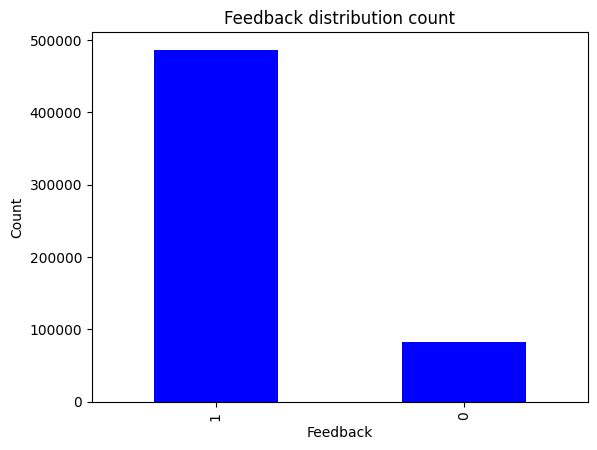

In [79]:
# Bar graph to visualize the total counts of each feedback category (0 and 1)
data['feedback'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [80]:
# Finding the percentage distribution of each feedback category
print(f"Feedback value count - percentage distribution: \n{round(data['feedback'].value_counts()/data.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
feedback
1    85.57
0    14.43
Name: count, dtype: float64


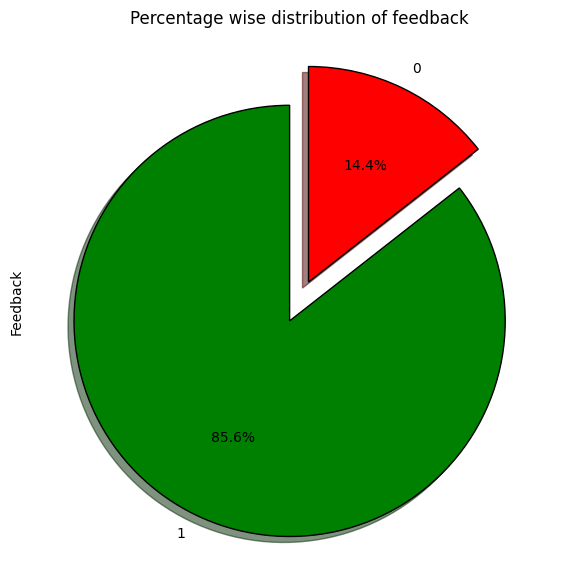

In [81]:
# 1. Prepare the data (Percentages for the feedback column)
tags = data['feedback'].value_counts() / data.shape[0]

# 2. Set up the figure and styling
fig = plt.figure(figsize=(7,7))
colors = ('green', 'red') # Green for Positive (1), Red for Negative (0)
wp = {'linewidth': 1, "edgecolor": 'black'}
explode = (0.1, 0.1)

# 3. Create the pie chart
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, 
          startangle=90, wedgeprops=wp, explode=explode)

# 4. Add labeling
plt.title('Percentage wise distribution of feedback')
plt.ylabel('Feedback')
plt.show()

In [82]:
# 1. See which ratings are in the 'Negative' (0) feedback category
print("Ratings for Feedback = 0:")
print(data[data['feedback'] == 0]['Score'].value_counts())

print("\n" + "-"*30 + "\n")

# 2. See which ratings are in the 'Positive' (1) feedback category
print("Ratings for Feedback = 1:")
print(data[data['feedback'] == 1]['Score'].value_counts())

Ratings for Feedback = 0:
Score
1    52264
2    29743
Name: count, dtype: int64

------------------------------

Ratings for Feedback = 1:
Score
5    363102
4     80654
3     42638
Name: count, dtype: int64


In [83]:
# Analyzing the distribution of products in your dataset
print(f"Product ID value count: \n{data['ProductId'].value_counts()}")

Product ID value count: 
ProductId
B007JFMH8M    913
B0026RQTGE    632
B002QWP89S    632
B002QWHJOU    632
B002QWP8H0    632
             ... 
B004DSPTTM      1
B008C9QWU8      1
B007O5A6BM      1
B003Q4TZ08      1
B001LR2CU2      1
Name: count, Length: 74257, dtype: int64


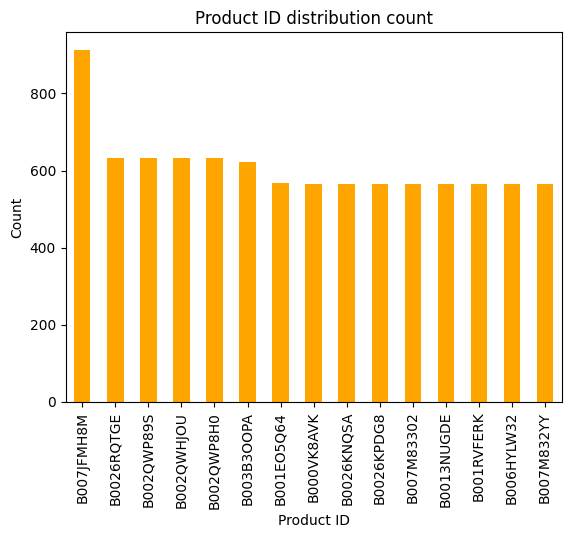

In [84]:
# Bar graph to visualize the top 15 most frequent Product IDs
data['ProductId'].value_counts().head(15).plot.bar(color = 'orange')

# Adding labels to match your tutorial style
plt.title('Product ID distribution count')
plt.xlabel('Product ID')
plt.ylabel('Count')
plt.show()

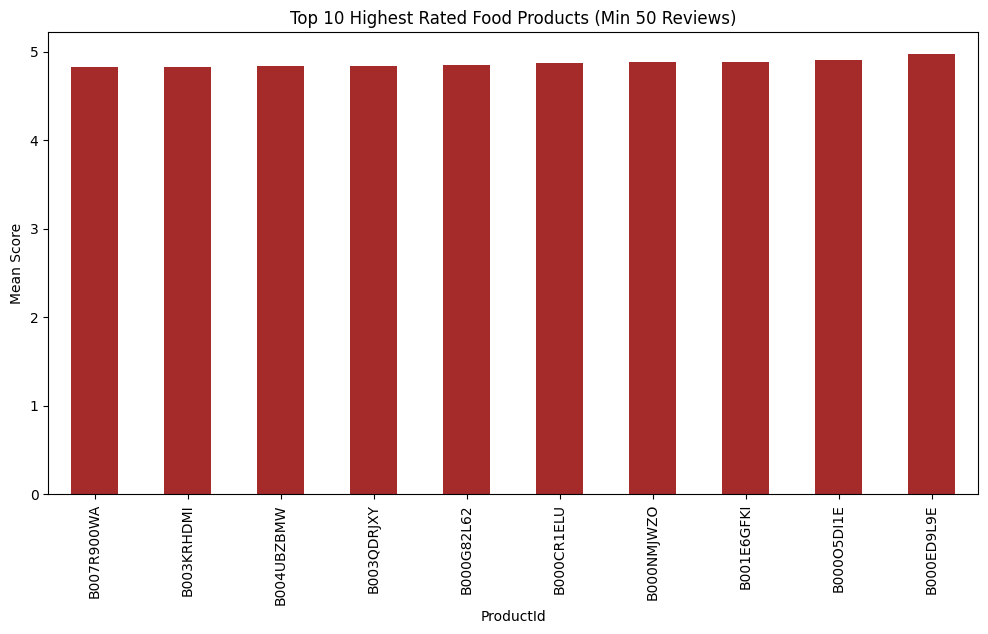

In [85]:
# Grouping by ProductId and finding the mean score
# We filter for products with at least 50 reviews to ensure the average is reliable
top_products = data['ProductId'].value_counts()[data['ProductId'].value_counts() > 50].index
mean_ratings = data[data['ProductId'].isin(top_products)].groupby('ProductId')['Score'].mean().sort_values()

# Plotting the 10 lowest and 10 highest rated frequent products
plt.figure(figsize=(12, 6))
mean_ratings.tail(10).plot.bar(color='brown')
plt.title('Top 10 Highest Rated Food Products (Min 50 Reviews)')
plt.ylabel('Mean Score')
plt.show()

In [86]:
# 1. Group by ProductId and find the average score for each food item
food_stats = data.groupby('ProductId')['Score'].mean().sort_values(ascending=False)

# 2. Print the top 10 highest-rated food products
print("Top 10 Highest Rated Food Products (Average Score):")
print(food_stats.head(10))

Top 10 Highest Rated Food Products (Average Score):
ProductId
B002149OUK    5.0
B002PDYN44    5.0
B002P9QAJE    5.0
B002P9QRCO    5.0
B002PA1KW0    5.0
B002PA7466    5.0
B002PAHIWQ    5.0
B002PAJFGS    5.0
B002PALD4K    5.0
B002PANI1G    5.0
Name: Score, dtype: float64


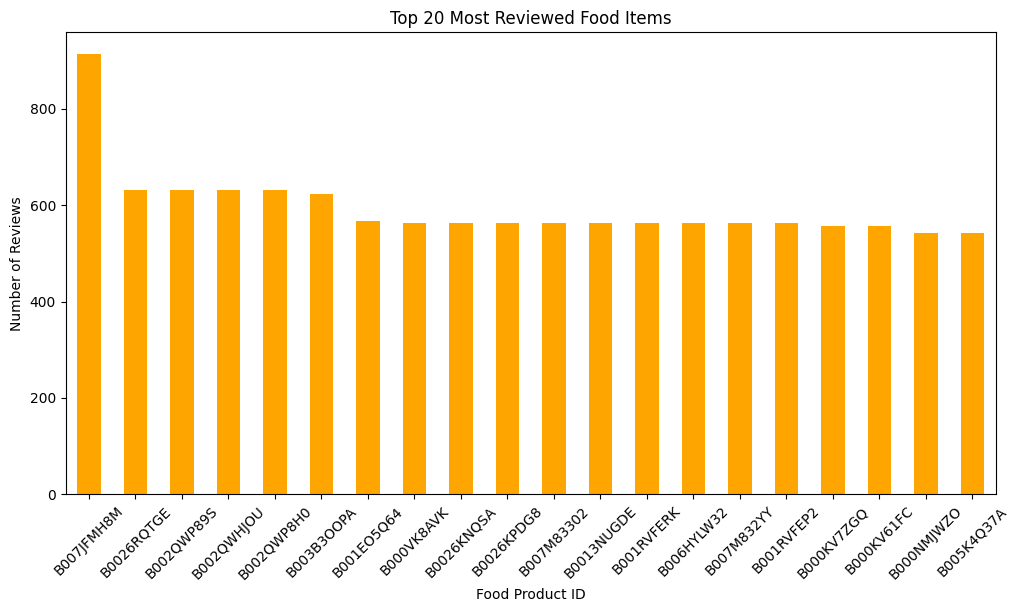

In [87]:


# Plotting the top 20 most-reviewed food products
plt.figure(figsize=(12, 6))
data['ProductId'].value_counts().head(20).plot.bar(color='orange')

plt.title('Top 20 Most Reviewed Food Items')
plt.xlabel('Food Product ID')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

In [88]:
# Statistical summary of the 'length' column
data['length'].describe()

count    568401.000000
mean        436.246170
std         445.351629
min          12.000000
25%         179.000000
50%         302.000000
75%         527.000000
max       21409.000000
Name: length, dtype: float64

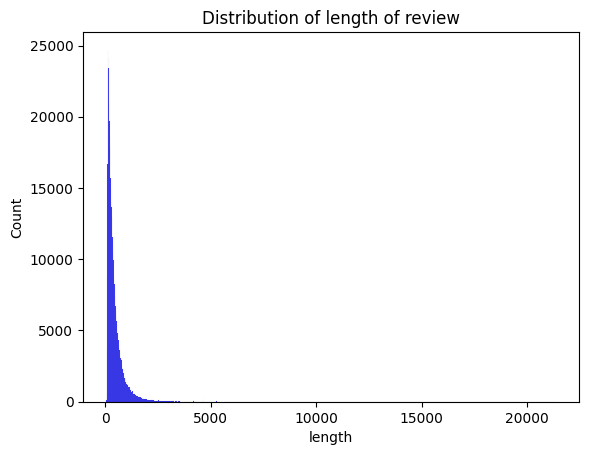

In [89]:
sns.histplot(data['length'], color='blue').set(title='Distribution of length of review')
plt.show()

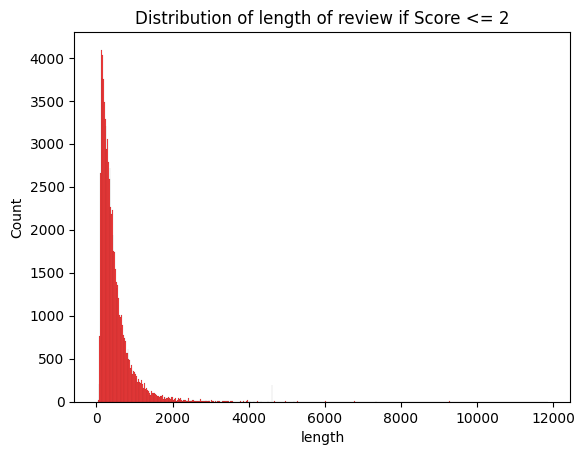

In [90]:
# Visualizing length for negative reviews (Score 1 or 2)
# We filter the data where Score is less than or equal to 2
sns.histplot(data[data['Score'] <= 2]['length'], color='red').set(title='Distribution of length of review if Score <= 2')
plt.show()

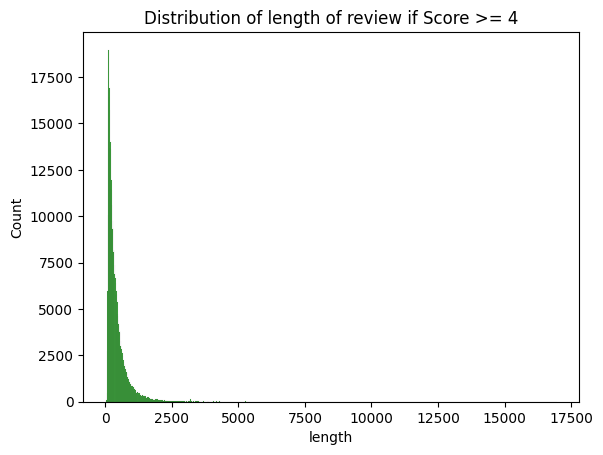

In [91]:
# Visualizing length for positive reviews (Score 4 or 5)
sns.histplot(data[data['Score'] >= 4]['length'], color='green').set(title='Distribution of length of review if Score >= 4')
plt.show()

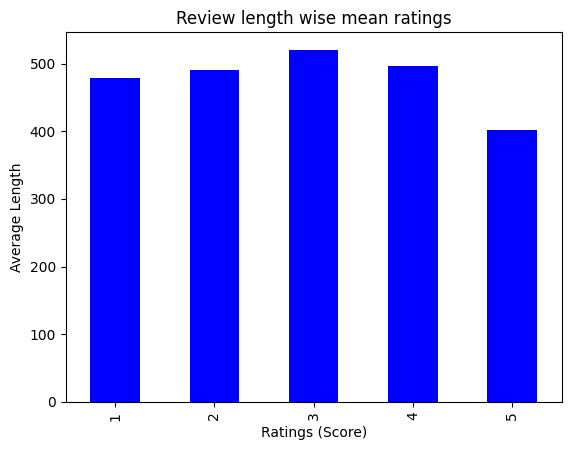

In [92]:
# Grouping by Score and finding the average length for each rating level
# This exactly replicates the logic shown in your reference image
data.groupby('Score')['length'].mean().plot.bar(color='blue')

# Adding labels to match your specific dataset
plt.title('Review length wise mean ratings')
plt.xlabel('Ratings (Score)')
plt.ylabel('Average Length')
plt.show()

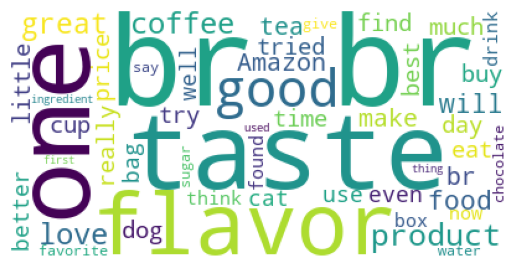

In [93]:
# Take a random sample of 1000 reviews to speed it up
sampled_data = data['Text'].dropna().sample(n=1000, random_state=42).astype(str)
reviews_combined = " ".join(sampled_data)

wc = WordCloud(background_color='white', max_words=50).generate(reviews_combined)
plt.imshow(wc)
plt.axis('off')
plt.show()

In [94]:
# 1. Isolate reviews by Score (1-2 is Negative, 4-5 is Positive)
neg_reviews_series = data[data['Score'] <= 2]['Text'].dropna().astype(str).str.lower()
pos_reviews_series = data[data['Score'] >= 4]['Text'].dropna().astype(str).str.lower()

# 2. Convert to sets of words (Sets are 100x faster for 'not in' logic)
neg_words_set = set(" ".join(neg_reviews_series).split())
pos_words_set = set(" ".join(pos_reviews_series).split())

# 3. Extract unique words (Same logic as Image 39, but optimized)
unique_negative = " ".join([word for word in neg_words_set if word not in pos_words_set])
unique_positive = " ".join([word for word in pos_words_set if word not in neg_words_set])

print(f"Logic complete. Unique Negative: {len(unique_negative.split())} words.")

Logic complete. Unique Negative: 62277 words.


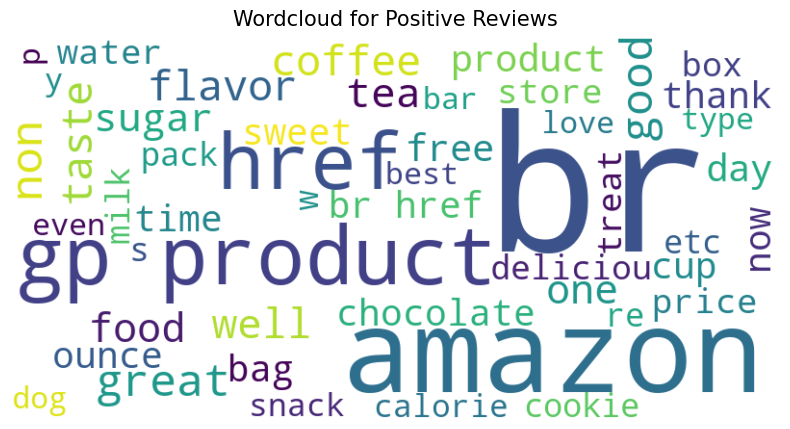

In [95]:
# Initialize for Positive
wc_pos = WordCloud(background_color='white', max_words=50, width=800, height=400)

plt.figure(figsize=(10, 5))
plt.imshow(wc_pos.generate(unique_positive), interpolation='bilinear')
plt.title('Wordcloud for Positive Reviews', fontsize=15)
plt.axis('off')
plt.show()

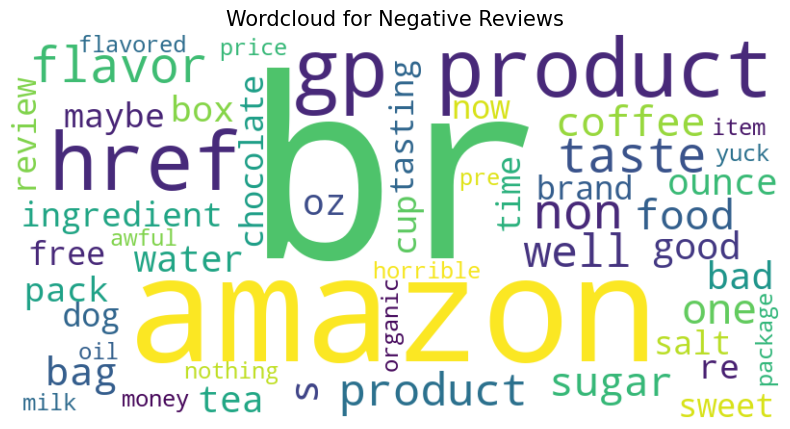

In [96]:
#from wordcloud import WordCloud

wc_neg = WordCloud(background_color='white', max_words=50, width=800, height=400)

plt.figure(figsize=(10, 5))
plt.imshow(wc_neg.generate(unique_negative), interpolation='bilinear')
plt.title('Wordcloud for Negative Reviews', fontsize=15)
plt.axis('off')
plt.show()

In [97]:
corpus =[]
stemmer = PorterStemmer()
for i in range(0,data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', data['Text'].iloc[i])
    review = review.lower()
    review = review.split()
    review = [stemmer.stem(word) for word in review if word not in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

In [98]:
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(corpus)   # keep sparse (faster, better)
y = data['feedback'].iloc[:X.shape[0]].values

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (568401, 2500)
y shape: (568401,)


In [99]:
#Saving the CountVectorizer model
pickle.dump(cv, open('count_vectorizer_model.pkl', 'wb'))

In [100]:
print(f"X shape: {X.shape}")
print(f"y shape: {len(y)}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)
print(f"X train shape: {X_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"y train shape: {y_train.shape}")
print(f"y test shape: {y_test.shape}")

X shape: (568401, 2500)
y shape: 568401
X train shape: (454720, 2500)
X test shape: (113681, 2500)
y train shape: (454720,)
y test shape: (113681,)


In [101]:
print(f"X train max value: {X_train.max()}")
print(f"y train max value: {y_train.max()}")

X train max value: 143
y train max value: 1


In [102]:
#Fitting scaled X_train and y_train to Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train,y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [103]:
#Accuracy of the model on training and testing data

print(f"Training Accuracy: {model_rf.score(X_train, y_train)}")
print(f"Testing Accuracy: {model_rf.score(X_test, y_test)}")

Training Accuracy: 0.9999274278676988
Testing Accuracy: 0.9347648243769847


In [104]:
#Predicting on the test set
y_pred = model_rf.predict(X_test)

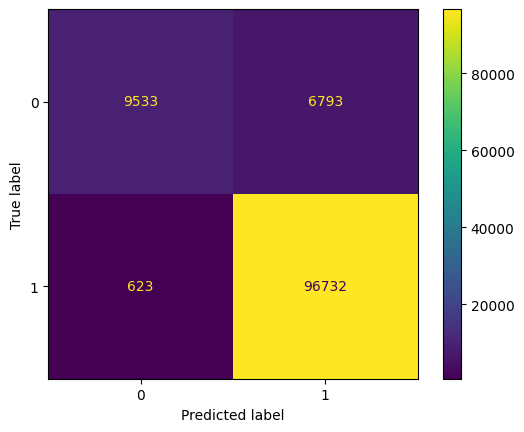

In [105]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [106]:
#k fold cross validation
accuracies = cross_val_score(estimator=model_rf, X=X_train, y=y_train, cv=5)
print(f"Accuracy: {accuracies.mean()}")
print(f"Standard Deviation: {accuracies.std()}")

Accuracy: 0.9314347290640393
Standard Deviation: 0.0003750575770341409


In [107]:
#applying grid search to get the optimal parameters for Random Forest Classifier
params={
    'bootstrap':[True],
    'max_depth':[80,100],
    'min_samples_split':[8,12],
    'n_estimators':[100,300]
}

In [108]:
cv_object=StratifiedKFold(n_splits=2)
grid_search=GridSearchCV(estimator=model_rf,param_grid=params,cv=cv_object,verbose=0,return_train_score=True)
grid_search.fit(X_train,y_train)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestClassifier()
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'bootstrap': [True], 'max_depth': [80, 100], 'min_samples_split': [8, 12], 'n_estimators': [100, 300]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo...shuffle=False)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and para

In [109]:
#Getting the best parameters from grid search
best_params=grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 300}


In [110]:
print("Cross validation mean accuracy on train data set: {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test data set: {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set:",accuracy_score(y_test,y_pred))

Cross validation mean accuracy on train data set: 95.87287231703026
Cross validation mean accuracy on test data set: 91.18548227480647
Accuracy score for test set: 0.9347648243769847


In [111]:
#XGBoost Classifier
model_xgb = XGBClassifier()
model_xgb.fit(X_train,y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [112]:
#Accuracy of the XGBoost model on training and testing data
print(f"XGBoost Training Accuracy: {model_xgb.score(X_train, y_train)}")
print(f"XGBoost Testing Accuracy: {model_xgb.score(X_test, y_test)}")

XGBoost Training Accuracy: 0.916225369458128
XGBoost Testing Accuracy: 0.9098266201036233


In [113]:
y_preds = model_xgb.predict(X_test) 

#confusion matrix for XGBoost model
cm_xgb = confusion_matrix(y_test, y_preds)  
print(cm_xgb)

[[ 7594  8732]
 [ 1519 95836]]


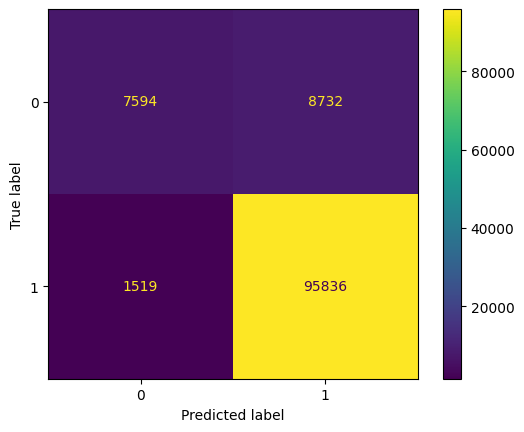

In [114]:
cm_display_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=model_xgb.classes_)
cm_display_xgb.plot()
plt.show()

In [115]:
pickle.dump(model_xgb, open('xgboost_model.pkl', 'wb'))

In [116]:
model_dt=DecisionTreeClassifier()
model_dt.fit(X_train,y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",None
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the curre

In [117]:
#accuracy of Decision Tree model
print(f"Decision Tree Training Accuracy: {model_dt.score(X_train, y_train)}")
print(f"Decision Tree Testing Accuracy: {model_dt.score(X_test, y_test)}")

Decision Tree Training Accuracy: 0.9999384236453202
Decision Tree Testing Accuracy: 0.906000123151626


In [118]:
y_pred_dt = model_dt.predict(X_test)

#confusion matrix for Decision Tree model
cm_dt = confusion_matrix(y_test, y_pred_dt)
print(cm_dt)

[[10835  5491]
 [ 5195 92160]]


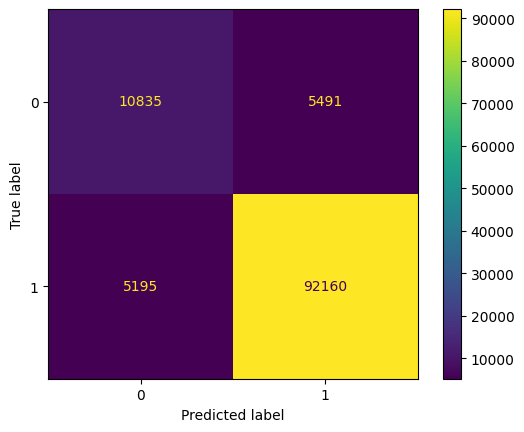

In [119]:
cm_display_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=model_dt.classes_)
cm_display_dt.plot()
plt.show()